> Data: 07.30.2025

# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## 1. Obtain the Data
Get the Dogs vs Cats dataset, randomly choose 2500 dog images and cat images (total 5000 images) to put in the "dogs-vs-cats_5000" folder.

In [30]:
# Import libraries
import os
import shutil
import pathlib

# Define source and target folders
source_dir = pathlib.Path('./data/train')
target_dir = pathlib.Path('./data/dogs-vs-cats_5000')

# delete it entirely if the folder exists
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Create the target foder
os.makedirs(target_dir, exist_ok=True)

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = target_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=source_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 2. EDA: Explore the data with relevant graphs, statistics, and insights
### 2.1 Basic statistics and category distribution bar charts
(1) Calculate category distribution (number of cat/dog images)

(2) Display image size distribution

(3) Category distribution bar chart

Calculate category distribution:
 category
cat    2500
dog    2500
Name: count, dtype: int64

Image size distribution:
              width       height
count  5000.000000  5000.000000
mean    403.882600   360.564600
std     108.659451    96.611042
min      59.000000    41.000000
25%     322.000000   300.000000
50%     440.000000   374.000000
75%     499.000000   418.250000
max    1050.000000   768.000000


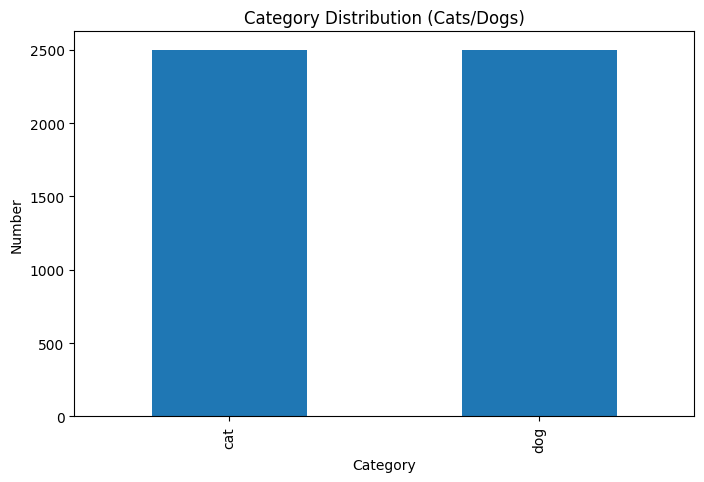

In [31]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the directory containing the image data
data_dir = './data/dogs-vs-cats_5000/train'

# Initialize lists to store file information
files = []        # To store filenames
categories = []   # To store the category (cat or dog) for each file
sizes = []        # To store image dimensions (width, height)

# Iterate through subfolders ('cat', 'dog'), read files, and label categories
for category in ['cat', 'dog']:
    folder_path = os.path.join(data_dir, category)
    for fname in os.listdir(folder_path):
        # Process only JPG or PNG image files
        if fname.endswith('.jpg') or fname.endswith('.png'):
            files.append(fname)
            categories.append(category)
            
            # Open the image to get its dimensions
            img_path = os.path.join(folder_path, fname)
            img = Image.open(img_path)
            sizes.append(img.size)

# Create a Pandas DataFrame from the collected data
df = pd.DataFrame({'filename': files, 'category': categories})
# Create a separate DataFrame for image sizes
df_sizes = pd.DataFrame(sizes, columns=['width', 'height'])

# Print the distribution of categories
print("Calculate category distribution:\n", df['category'].value_counts())
# Print a descriptive summary of image sizes
print("\nImage size distribution:\n", df_sizes.describe())


## Plotting Image Category Distribution
# Create a figure for the plot
plt.figure(figsize=(8, 5))
# Generate a bar plot of category counts
df['category'].value_counts().plot(kind='bar')
# Set plot title and labels
plt.title('Category Distribution (Cats/Dogs)')
plt.xlabel('Category')
plt.ylabel('Number')
# Display the plot
plt.show()

### 2.2 Visualization data (Randomly display images)

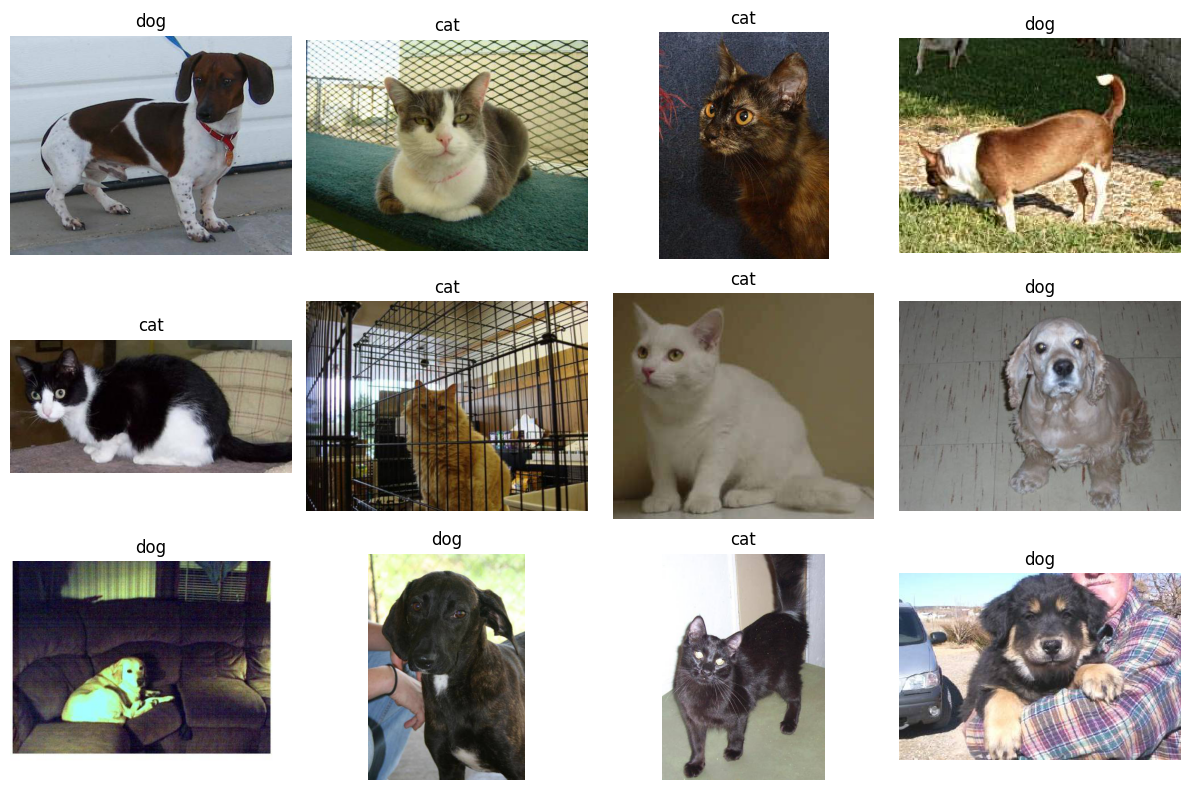

In [ ]:
# Import library
import random

# Read all filenames from subfolders, and store their paths and labels.
all_files = []
all_labels = []

for category in ['cat', 'dog']:
    folder_path = os.path.join(data_dir, category)
    files = os.listdir(folder_path)
    for f in files:
        all_files.append(os.path.join(category, f))  # Add subfolder name as part of the path
        all_labels.append(category)

# Create a DataFrame mapping filenames to categories (optional)
df = pd.DataFrame({'filepath': all_files, 'category': all_labels})

# Randomly select 12 images (paths include subfolders)
sample_files = random.sample(list(df['filepath']), 12)

plt.figure(figsize=(12, 8))
for idx, filepath in enumerate(sample_files):
    full_path = os.path.join(data_dir, filepath)
    img = Image.open(full_path)
    plt.subplot(3, 4, idx + 1)
    plt.imshow(img)
    # Infer the category from the path
    plt.title('cat' if 'cat' in filepath else 'dog')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 2.3 Advanced exploration - comparison of image sizes of different categories

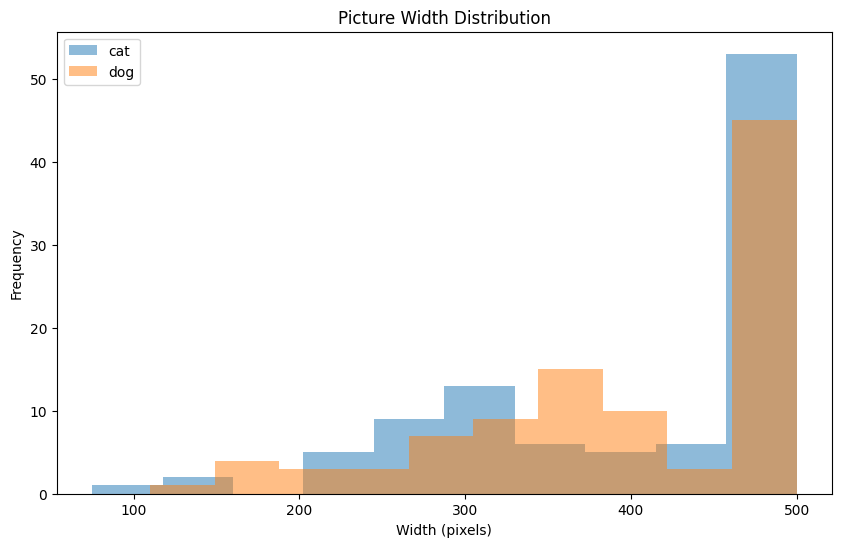

In [ ]:
# Create a list of full file paths with labels, including subfolders
all_files = []
for category in ['cat', 'dog']:
    folder_path = os.path.join(data_dir, category)
    for fname in os.listdir(folder_path):
        if fname.endswith('.jpg') or fname.endswith('.png'):
            all_files.append(os.path.join(category, fname))

# Get the sizes of the first 100 cat and dog images (maximum 100 each)
cat_sizes = []
dog_sizes = []
cat_count = 0
dog_count = 0

for f in all_files:
    if 'cat' in f and cat_count < 100:
        img = Image.open(os.path.join(data_dir, f))
        cat_sizes.append(img.size)
        cat_count += 1
    elif 'dog' in f and dog_count < 100:
        img = Image.open(os.path.join(data_dir, f))
        dog_sizes.append(img.size)
        dog_count += 1
    if cat_count >= 100 and dog_count >= 100:
        break

cat_widths = [w for w, h in cat_sizes]
dog_widths = [w for w, h in dog_sizes]

# Plotting the distribution of picture widths
plt.figure(figsize=(10, 6))
plt.hist(cat_widths, alpha=0.5, label='cat')
plt.hist(dog_widths, alpha=0.5, label='dog')
plt.legend()
plt.title('Picture Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

### 2.4 Insights and interpretations
- Balanced data volume: 50% of the dataset is cat and dog images, which helps stabilize model training.
- Image sizes vary: Consider resizing after steps.
- Check data quality: By randomly sampling images, it can quickly find damaged or abnormal images.

## 3. Train two networks (use callbacks to save the best model version)
### 3.1 Define a neural network of CNN (Convolutional Neural Network)
### 3.1.1 Load the data into three sets

In [14]:
# Import functions
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('./data/dogs-vs-cats_5000')

# Create datasets from the directory structure
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Define the model architecture
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Display the model summary
print("Model Summary:")
model.summary()

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Train the model with callbacks to save the best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model with CNN
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Model Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 476ms/step - accuracy: 0.5245 - loss: 0.6933 - val_accuracy: 0.5960 - val_loss: 0.6628
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 423ms/step - accuracy: 0.6240 - loss: 0.6441 - val_accuracy: 0.6080 - val_loss: 0.7025
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 417ms/step - accuracy: 0.6754 - loss: 0.6069 - val_accuracy: 0.6620 - val_loss: 0.6322
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - accuracy: 0.7054 - loss: 0.5684 - val_accuracy: 0.6280 - val_loss: 0.6603
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 437ms/step - accuracy: 0.7476 - loss: 0.5377 - val_accuracy: 0.7800 - val_loss: 0.4636
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - accuracy: 0.7846 - loss: 0.4583 - val_accuracy: 0.8130 - val_loss: 0.4288
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - accuracy: 0.8106 - loss: 0.4163 - val_accuracy: 0.7990 - val_loss: 0.4590
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - accuracy: 0.8339 - loss: 0

### 3.1.3 Displaying curves of loss and accuracy during training

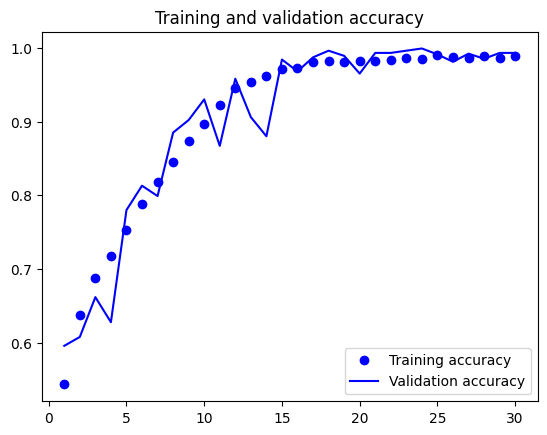

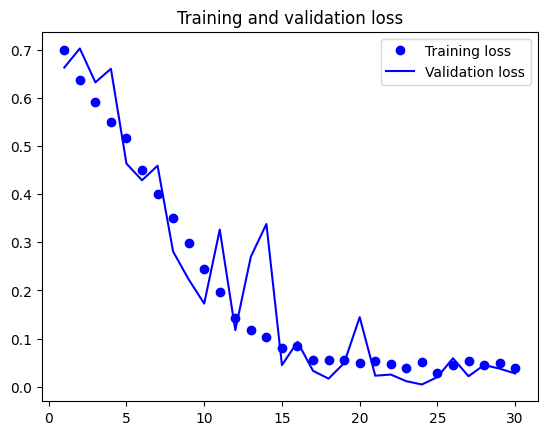

In [ ]:
# Displaying curves of loss and accuracy during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy and loss
# plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

- From the Training and validation accuracy figure, the dataset has high accuracy. Starting from about epoch 15, the model seems to have converged to a better state.
- From the Training and validation loss figure, there is a continuous and stable decrease in the loss function. This CNN model can have good generalization ability.

### 3.1.4 Evaluating the model on the test set

In [45]:
# Evaluate the model on the test set
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"CNN model test set accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9941 - loss: 0.0210
CNN model test set accuracy: 0.994


### 3.1.5 Define a data augmentation stage to add to an image model

In [50]:
# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### 3.1.6 Displaying some randomly augmented training images

2025-07-25 08:37:58.930176: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


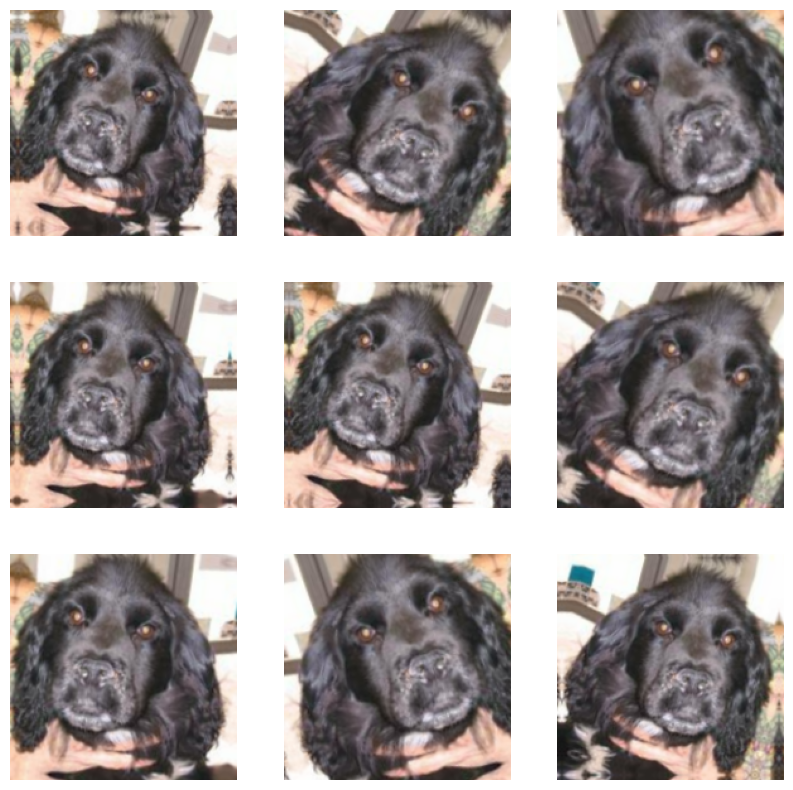

In [51]:
# Display some augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### 3.1.7 Defining a new convnet that includes image augmentation and dropout

In [53]:
# Define a new model that includes the data augmentation layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Display the model summary
print("Model Summary:")
model.summary()

Model Summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1.7 Training the regularized convnet

In [55]:
# Train the model with callbacks to save the best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model with data augmentation
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 488ms/step - accuracy: 0.6910 - loss: 0.5924 - val_accuracy: 0.7190 - val_loss: 0.5320
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 438ms/step - accuracy: 0.7125 - loss: 0.5760 - val_accuracy: 0.6030 - val_loss: 0.7173
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 494ms/step - accuracy: 0.7101 - loss: 0.5588 - val_accuracy: 0.5690 - val_loss: 0.8073
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 529ms/step - accuracy: 0.7326 - loss: 0.5510 - val_accuracy: 0.7160 - val_loss: 0.6158
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 514ms/step - accuracy: 0.7514 - loss: 0.5283 - val_accuracy: 0.7390 - val_loss: 0.5629
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 534ms/step - accuracy: 0.7599 - loss: 0.4982 - val_accuracy: 0.7890 - val_loss: 0.4431
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 556ms/step - accuracy: 0.7708 - loss: 0.4860 - val_accuracy: 0.7930 - val_loss: 0.4530
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 472ms/step - accuracy: 0.7766 -

### 3.1.8 Evaluating the model on the test set

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9540 - loss: 0.1201
Test accuracy: 0.952


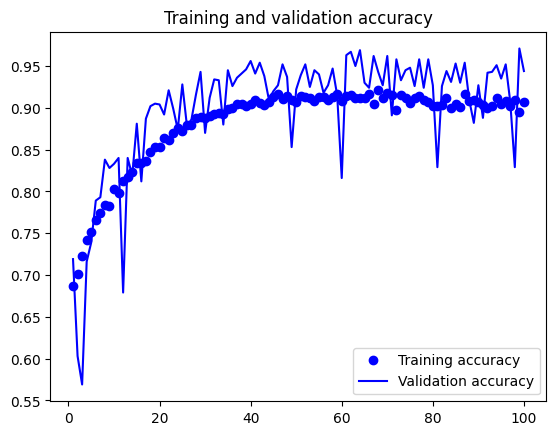

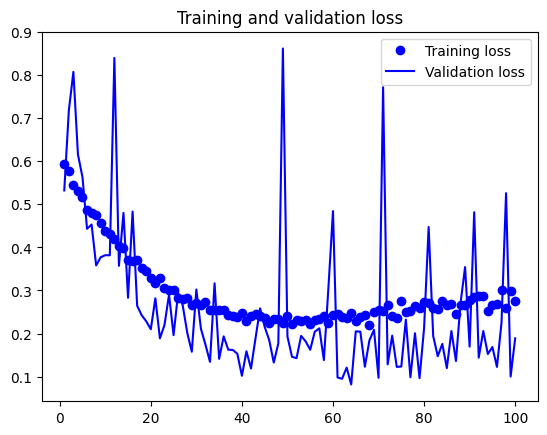

In [57]:
# Evaluate the model on the test set
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# Displaying curves of loss and accuracy during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

- From the Training and validation accuracy figure, after approximately 20 epochs, the training and validation accuracy stabilized. However, there were significant differences in the peaks and valleys within the training set.
- From the Training and validation loss figure, after approximately 20 epochs, the training loss continues to decrease, with fluctuations in its level slowly. After approximately 40 epochs, the training loss stabilizes. The training loss amplitude is much larger, suggesting that the validation loss is significantly higher than the training loss.

### 3.2 Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph
### 3.2.1 Feature extraction with a pretrained model

In [58]:
# Import the VGG16 model from Keras applications
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# Display the summary of the VGG16 model
print("VGG16 Model Summary:")
conv_base.summary()

VGG16 Model Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2.2 Fast feature extraction without data augmentation
Extracting the VGG16 features and corresponding labels

In [59]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('./data/dogs-vs-cats_5000')

# Create datasets from the directory structure
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [60]:
# Import library
import numpy as np

# Function to extract features and labels from the dataset
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features and labels from the datasets
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

# Display the shape of the extracted features
print("Shape of extracted features:", train_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

2025-07-25 13:01:16.336484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

### 3.2.3 Defining and training the densely connected classifier

In [61]:
# Define the densely connected classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Model summary
print("Dense Classifier Model Summary:")
model.summary()

Dense Classifier Model Summary:


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Train the model with callbacks to save the best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# Train the model with the extracted features
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9133 - loss: 16.9216 - val_accuracy: 0.9900 - val_loss: 0.6496
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9769 - loss: 3.1898 - val_accuracy: 0.9910 - val_loss: 0.6500
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9898 - loss: 1.3329 - val_accuracy: 0.9950 - val_loss: 0.7109
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9897 - loss: 1.2911 - val_accuracy: 0.9950 - val_loss: 0.2712
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9917 - loss: 1.1553 - val_accuracy: 0.9990 - val_loss: 0.1708
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9909 - loss: 0.9664 - val_accuracy: 0.9950 - val_loss: 0.4743
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9958 - loss: 0.3471 - val_accuracy: 0.9970 - val_loss: 0.0510
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9990 - loss: 0.1358 - val_acc

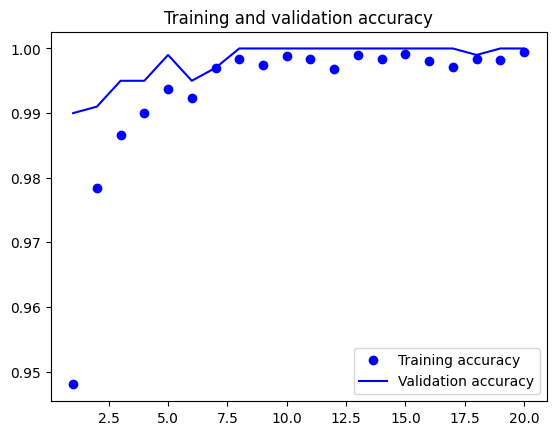

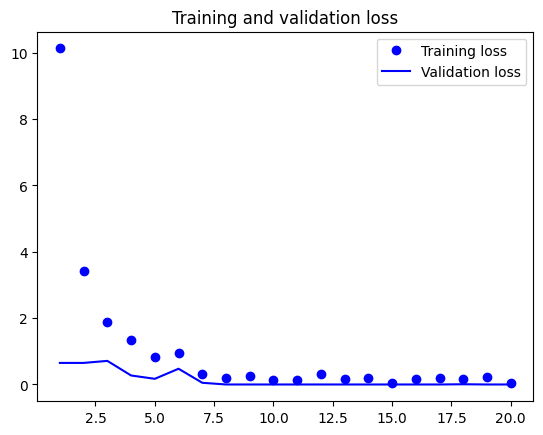

In [63]:
# Plotting curves of loss and accuracy during training
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [64]:
# Evaluate the model on the test set
test_model = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Densely connected classifier test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Densely connected classifier test accuracy: 1.000


### 3.2.4 Feature extraction together with data augmentation

In [65]:
# Instantiating and freezing the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Display the summary of the VGG16 model
print("VGG16 Model with Data Augmentation Summary:")
conv_base.summary()

VGG16 Model with Data Augmentation Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Printing the list of trainable weights before and after freezing

In [66]:
# The number of trainable weights after freezing the conv base
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Adding a data augmentation stage and a classifier to the convolutional base

In [67]:
# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Define a new model that includes the data augmentation layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Model summary
print("Model Summary with Data Augmentation:")
model.summary()

Model Summary with Data Augmentation:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_15[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12800)     │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  3,277,056 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [70]:
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Train the model with callbacks to save the best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model with data augmentation
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9682 - loss: 1.4166 - val_accuracy: 0.9850 - val_loss: 0.8202
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9729 - loss: 1.0849 - val_accuracy: 0.9940 - val_loss: 0.2378
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9716 - loss: 0.9363 - val_accuracy: 0.9950 - val_loss: 0.1891
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.9624 - loss: 1.0193 - val_accuracy: 0.9960 - val_loss: 0.1645
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9711 - loss: 0.7705 - val_accuracy: 0.9960 - val_loss: 0.0877
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9721 - loss: 0.7186 - val_accuracy: 0.9920 - val_loss: 0.1655
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.9709 - loss: 0.5796 - val_accuracy: 0.9880 - val_loss: 0.3451
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9715 - loss: 0.5647 - val_accu

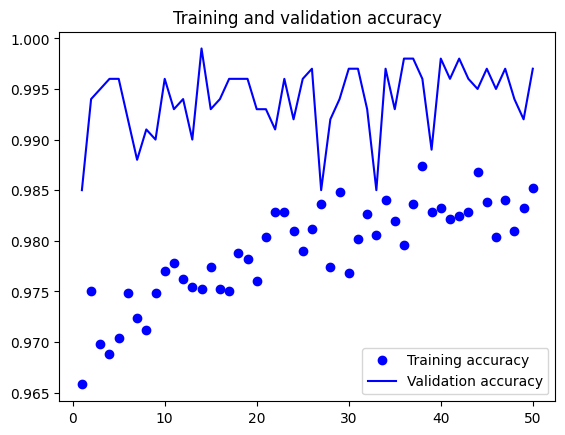

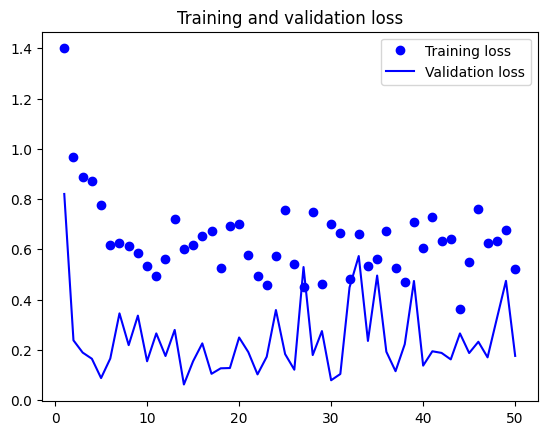

In [71]:
# Displaying curves of loss and accuracy during training
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy and loss
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [72]:
# Evaluate the model on the test set
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9931 - loss: 0.0995
Test accuracy: 0.995


### 3.2.5 Fine-tuning the model

In [73]:
# Display the summary of the VGG16 model
print("VGG16 Model Summary:")
conv_base.summary()

# Freeze all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Display the summary of the VGG16 model with fine-tuning
print("VGG16 Model with Fine-tuning Summary:")
model.summary()

VGG16 Model Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 Model with Fine-tuning Summary:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_15[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12800)     │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  3,277,056 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,316 (81.14 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 3,277,315 (12.50 MB)

In [74]:
# Define the model architecture using VGG16 as the base
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

# Set up ModelCheckpoint, train the model with callbacks to save the best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model with the VGG16 base
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.9783 - loss: 0.8347 - val_accuracy: 0.9920 - val_loss: 0.4491
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9844 - loss: 0.4635 - val_accuracy: 0.9930 - val_loss: 0.5451
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9914 - loss: 0.2561 - val_accuracy: 0.9960 - val_loss: 0.3259
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9904 - loss: 0.3042 - val_accuracy: 0.9950 - val_loss: 0.2796
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.9881 - loss: 0.3308 - val_accuracy: 0.9950 - val_loss: 0.2713
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.9869 - loss: 0.3173 - val_accuracy: 0.9940 - val_loss: 0.2202
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - accuracy: 0.9883 - loss: 0.2032 - val_accuracy: 0.9960 - val_loss: 0.1763
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.9902 - loss: 0.2663 - val_accu

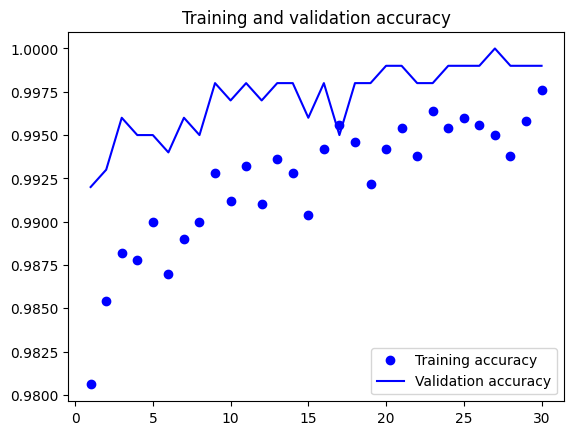

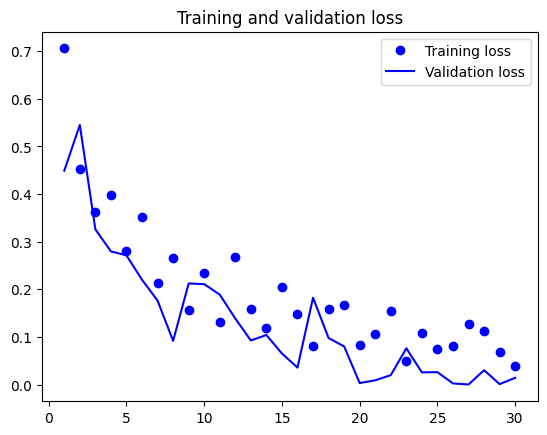

In [75]:
# Displaying curves of loss and accuracy during training
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy and loss
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [76]:
# Evaluate the model on the test set
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"VGG16 Model test set accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9972 - loss: 0.0186
VGG16 Model test set accuracy: 0.998


## 4. Explore the relative performance of the models
### 4.1 Load the best version of both models

In [3]:
# Import function
from tensorflow import keras

# Load the best model previously saved using ModelCheckpoint
cnn_model = keras.models.load_model("./models/convnet_from_scratch_with_augmentation.keras")
vgg_model = keras.models.load_model("./models/fine_tuning.keras")

### 4.2 Obtain test data and labels

In [ ]:
# Import libraries and function
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory

# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('./data/dogs-vs-cats_5000')

# Create datasets from the directory structure
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180), # Adjust according to your model input size
    batch_size=32,
    shuffle=False # For easier ordering later

Found 2000 files belonging to 2 classes.


In [9]:
# Import library
import numpy as np

# Get the test set images and correct labels using numpy arrays
y_true = []
for images, labels in test_dataset:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true)  # real labels

2025-07-29 23:05:24.986229: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 4.3 Perform predictions on the test set and get the class label (0 or 1)

In [10]:
# Get the predicted probability of the CNN model
y_pred_cnn_prob = cnn_model.predict(test_dataset)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

# Get the predicted probability of the VGG16 model
y_pred_vgg_prob = vgg_model.predict(test_dataset)
y_pred_vgg = (y_pred_vgg_prob > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step


### 4.4 Calculate Accuracy, Confusion Matrix, Precision, Recall, F1 Score

In [11]:
# Import functions
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Display the Accuracy, Confusion Matrix, Precision, Recall, F1 Score
def print_metrics(y_true, y_pred, model_name):
    print(f"===== Metrics of {model_name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print()

print_metrics(y_true, y_pred_cnn, "CNN from Scratch")
print_metrics(y_true, y_pred_vgg, "Fine-Tuned VGG16")

===== Metrics of CNN from Scratch =====
Accuracy: 0.9525
Confusion Matrix:
 [[930  70]
 [ 25 975]]
Precision: 0.9330143540669856
Recall: 0.975
F1 Score: 0.9535452322738386

===== Metrics of Fine-Tuned VGG16 =====
Accuracy: 0.9975
Confusion Matrix:
 [[999   1]
 [  4 996]]
Precision: 0.9989969909729187
Recall: 0.996
F1 Score: 0.9974962443665498



### 4.5 Plotting the Precision-Recall Curve

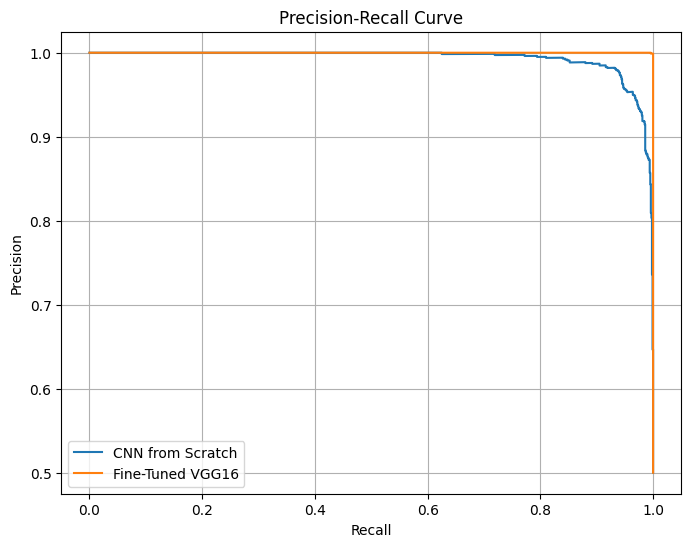

In [12]:
# Import library and function
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# define plot_precision_recall
def plot_precision_recall(y_true, y_scores, label):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=label)

# Display Precision-Recall Curve
plt.figure(figsize=(8,6))
plot_precision_recall(y_true, y_pred_cnn_prob, "CNN from Scratch")
plot_precision_recall(y_true, y_pred_vgg_prob, "Fine-Tuned VGG16")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

### 4.6 Exploring examples of model mispredictions

2025-07-29 23:09:31.529800: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


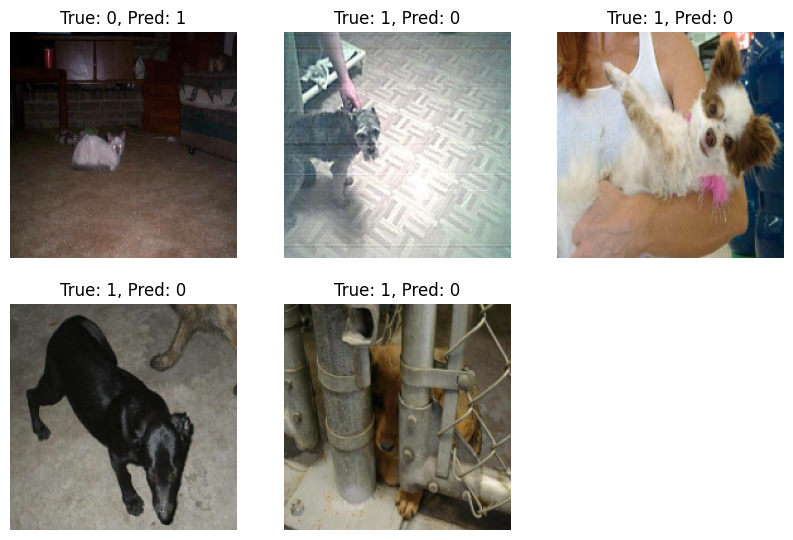

In [13]:
# Import library
import matplotlib.pyplot as plt

# First collect incorrect classification information (take Fine-Tuned VGG16 as an example)
incorrect_indices = np.where(y_pred_vgg != y_true)[0]

# Extract these incorrect images from test_dataset
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

for i, (images, labels) in enumerate(test_dataset.unbatch()):
    if i in incorrect_indices:
        incorrect_images.append(images.numpy())
        incorrect_labels.append(labels.numpy())
        incorrect_preds.append(y_pred_vgg[i])
    if len(incorrect_images) >= 9: # Display the first 9 incorrect examples
        break

# Display the images and the true and predicted labels.
plt.figure(figsize=(10,10))
for i in range(len(incorrect_images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(incorrect_images[i].astype("uint8"))
    plt.title(f"True: {incorrect_labels[i]}, Pred: {incorrect_preds[i]}")
    plt.axis("off")
plt.show()

## 5. Conclusions
1. The fine-tuned VGG16 model significantly outperforms a CNN trained from scratch:

    Test results show that the fine-tuned VGG16 achieves 99.75% accuracy, significantly higher than the CNN's 95.25%. Leveraging pre-trained weights for fine-tuning provides stronger performance and generalization in image feature extraction.

2. VGG16 leads in precision, recall, and F1 score:

    VGG16's Precision (~99.9%), Recall (~99.6%), and F1 score (~99.7%) all significantly outperform CNNs, indicating a more accurate and balanced approach to correctly identifying both positive and negative samples, reducing false positives and false negatives. 

3. Fine-tuning improves detail extraction and model stability, making it particularly suitable for data-limited situations:

    Fine-tuning, by unfreezing only some layer weights, can improve the model's adaptability to the target data and avoid overfitting. This suggests that this approach helps improve the model's ability to recover from minor misclassifications.

This experiment demonstrates that a VGG16 model fine-tuned using ImageNet pre-training can effectively outperform a traditional CNN trained from scratch in data-limited binary classification tasks, becoming a more robust and highly accurate solution.